In [1]:
import json

path = "data/keywords_db.jsonl"

data = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line.strip()))

print("Total records:", len(data))


Total records: 14108


In [3]:
!pip install anytree wordcloud -q


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


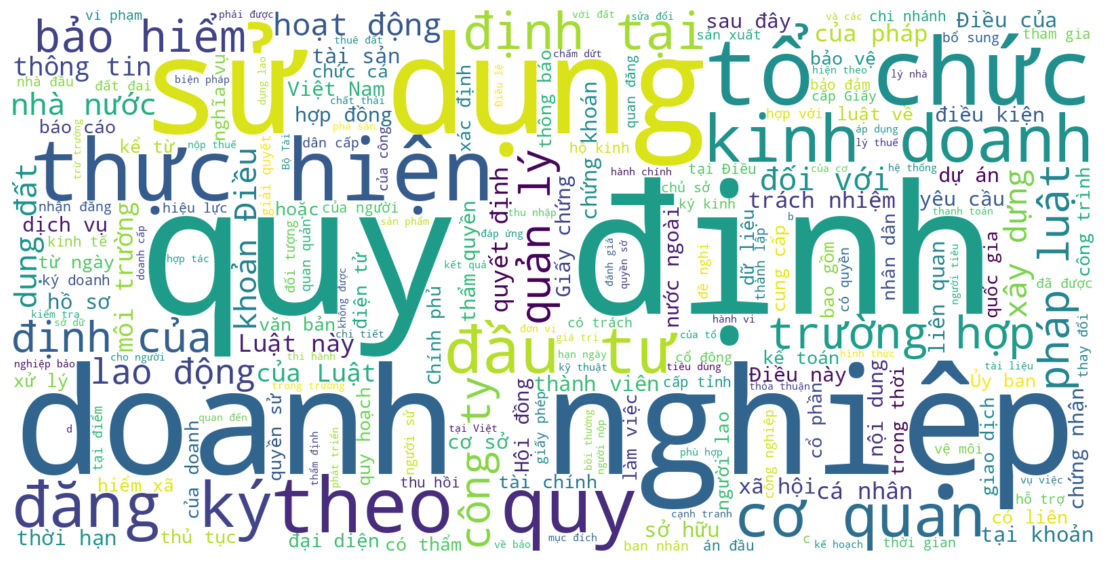

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join([item["clause_text"] for item in data])

wc = WordCloud(
    background_color='white',
    width=1600,
    height=800
).generate(all_text)


plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


✅ Loaded 14108 clauses
📌 Total unique Articles (Law × Article): 2700

===== 📊 THỐNG KÊ TỔNG QUAN =====
📌 Số Điều (unique by law + article): 2700
📌 Điều ngắn nhất (token): 33
📌 Điều dài nhất (token): 36681
📌 Trung bình: 480.59
📌 Median: 358.0
📌 Std: 839.16
📌 Percentile 25%: 229.0
📌 Percentile 50%: 358.0
📌 Percentile 75%: 557.25
📌 Percentile 90%: 864.0
📌 Percentile 95%: 1132.4499999999975
📌 Percentile 99%: 2074.41999999999

===== TOP 20 ĐIỀU DÀI NHẤT (token) =====
1. Luật Kinh doanh bảo hiểm 2022 số 08/2022/QH15 áp dụng năm 2025 mới nhất — Điều 66: 36681 tokens
2. Nghị định 23/2021/NĐ-CP hướng dẫn Luật Việc làm về doanh nghiệp hoạt động dịch vụ việc làm mới nhất — Điều 38: 10456 tokens
3. Luật Kinh doanh bảo hiểm 2022 số 08/2022/QH15 áp dụng năm 2025 mới nhất — Điều 30: 8542 tokens
4. Văn bản hợp nhất 67/VBHN-VPQH 2025 Luật Doanh nghiệp — Điều 218: 5844 tokens
5. Luật Chứng khoán năm 2019 số 54/2019/QH14 áp dụng năm 2025 mới nhất — Điều 4: 3989 tokens
6. Thông tư 05/2022/TT-BTC hướng dẫn

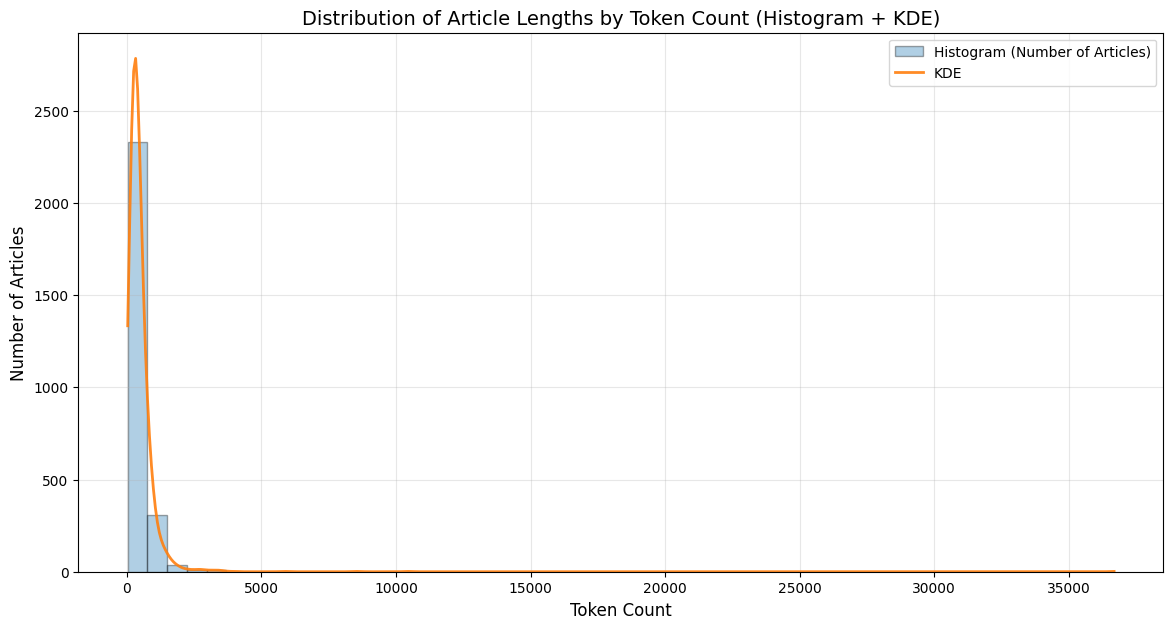

In [6]:
# =========================================
# 1️⃣ Import thư viện
# =========================================
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from transformers import AutoTokenizer

# =========================================
# 2️⃣ Load JSONL file
# =========================================
jsonl_file = "data/keywords_db.jsonl"

rows = []
with open(jsonl_file, "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

df = pd.DataFrame(rows)
print(f"✅ Loaded {len(df)} clauses")

# =========================================
# 3️⃣ Gộp tất cả clause_text theo (law_title, article_title)
#    → Mỗi Điều của mỗi Luật = 1 dòng
# =========================================

articles = (
    df.groupby(["law_title", "article_title"])["clause_text"]
    .apply(lambda x: "\n".join([str(t) for t in x]))
    .reset_index()
    .rename(columns={"clause_text": "full_article_text"})
)

print(f"📌 Total unique Articles (Law × Article): {len(articles)}")

# =========================================
# 4️⃣ Tokenize bằng tokenizer Vi-Qwen2-3B-RAG
# =========================================
tokenizer = AutoTokenizer.from_pretrained("AITeamVN/Vi-Qwen2-3B-RAG")

def count_tokens(text):
    return len(tokenizer(text, add_special_tokens=False)["input_ids"])

articles["token_count"] = articles["full_article_text"].apply(count_tokens)
articles["char_count"]  = articles["full_article_text"].apply(len)

# =========================================
# 5️⃣ Thống kê cơ bản
# =========================================
data = articles["token_count"].values

print("\n===== 📊 THỐNG KÊ TỔNG QUAN =====")
print(f"📌 Số Điều (unique by law + article): {len(articles)}")
print(f"📌 Điều ngắn nhất (token): {data.min()}")
print(f"📌 Điều dài nhất (token): {data.max()}")
print(f"📌 Trung bình: {data.mean():.2f}")
print(f"📌 Median: {np.median(data)}")
print(f"📌 Std: {np.std(data):.2f}")
print(f"📌 Percentile 25%: {np.percentile(data, 25)}")
print(f"📌 Percentile 50%: {np.percentile(data, 50)}")
print(f"📌 Percentile 75%: {np.percentile(data, 75)}")
print(f"📌 Percentile 90%: {np.percentile(data, 90)}")
print(f"📌 Percentile 95%: {np.percentile(data, 95)}")
print(f"📌 Percentile 99%: {np.percentile(data, 99)}")

# =========================================
# 6️⃣ Top 20 Điều dài nhất
# =========================================
articles_sorted = articles.sort_values("token_count", ascending=False)
print("\n===== TOP 20 ĐIỀU DÀI NHẤT (token) =====")
for i, row in enumerate(articles_sorted.head(20).itertuples(), 1):
    print(f"{i}. {row.law_title} — {row.article_title}: {row.token_count} tokens")

# =========================================
# 7️⃣ Histogram + KDE
# =========================================
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(14,7))

counts, bins, patches = plt.hist(
    data,
    bins=50,
    edgecolor="black",
    alpha=0.35,
    label="Histogram (Number of Articles)"
)

bin_width = bins[1] - bins[0]
plt.plot(
    x_vals,
    y_vals * len(data) * bin_width,
    linewidth=2,
    label="KDE",
    alpha=0.9
)

plt.title("Distribution of Article Lengths by Token Count (Histogram + KDE)", fontsize=14)
plt.xlabel("Token Count", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


✅ Loaded 14108 clauses


,law_title,article_id,article_title,article_link,clause_no,clause_text,id
0,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,1,Điều 1,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,0,luat_lao_dong dieu_1 khoan_0 Phạm vi điều chỉn...,luat_lao_dong_dieu_1_khoan_0
1,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,2,Điều 2,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,0,luat_lao_dong dieu_2 khoan_0 Đối tượng áp dụng,luat_lao_dong_dieu_2_khoan_0
2,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,2,Điều 2,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,1,"luat_lao_dong dieu_2 khoan_1 Người lao động, n...",luat_lao_dong_dieu_2_khoan_1
3,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,2,Điều 2,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,2,luat_lao_dong dieu_2 khoan_2 Người sử dụng lao...,luat_lao_dong_dieu_2_khoan_2
4,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,2,Điều 2,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,3,luat_lao_dong dieu_2 khoan_3 Người lao động nư...,luat_lao_dong_dieu_2_khoan_3



===== 📊 THỐNG KÊ TỔNG QUAN TRÊN KHOẢN =====
📌 Số khoản: 14108
📌 Khoản ngắn nhất (token): 14
📌 Khoản dài nhất (token): 2019
📌 Trung bình: 91.76
📌 Median: 67.0
📌 Std: 88.93
📌 Percentile 25%: 40.0
📌 Percentile 50%: 67.0
📌 Percentile 75%: 108.0
📌 Percentile 90%: 181.0
📌 Percentile 95%: 249.0
📌 Percentile 99%: 442.9300000000003

===== TOP 20 KHOẢN DÀI NHẤT (token) =====
1. Điều 27 / Khoản 1: 2019 tokens
2. Điều 38 / Khoản 4: 1210 tokens
3. Điều 43 / Khoản 6: 1157 tokens
4. Điều 38 / Khoản 1: 1132 tokens
5. Điều 137 / Khoản 1: 1096 tokens
6. Điều 63 / Khoản 2: 1094 tokens
7. Điều 9 / Khoản 1: 1067 tokens
8. Điều 71 / Khoản 2: 1039 tokens
9. Điều 133 / Khoản 1: 1010 tokens
10. Điều 28 / Khoản 1: 1001 tokens
11. Điều 42 / Khoản 1: 956 tokens
12. Điều 9 / Khoản 2: 953 tokens
13. Điều 119 / Khoản 2: 905 tokens
14. Điều 39 / Khoản 3: 898 tokens
15. Điều 74 / Khoản 2: 881 tokens
16. Điều 124 / Khoản 3: 870 tokens
17. Điều 109 / Khoản 2: 867 tokens
18. Điều 142 / Khoản 2: 867 tokens
19. Điều 23 / 

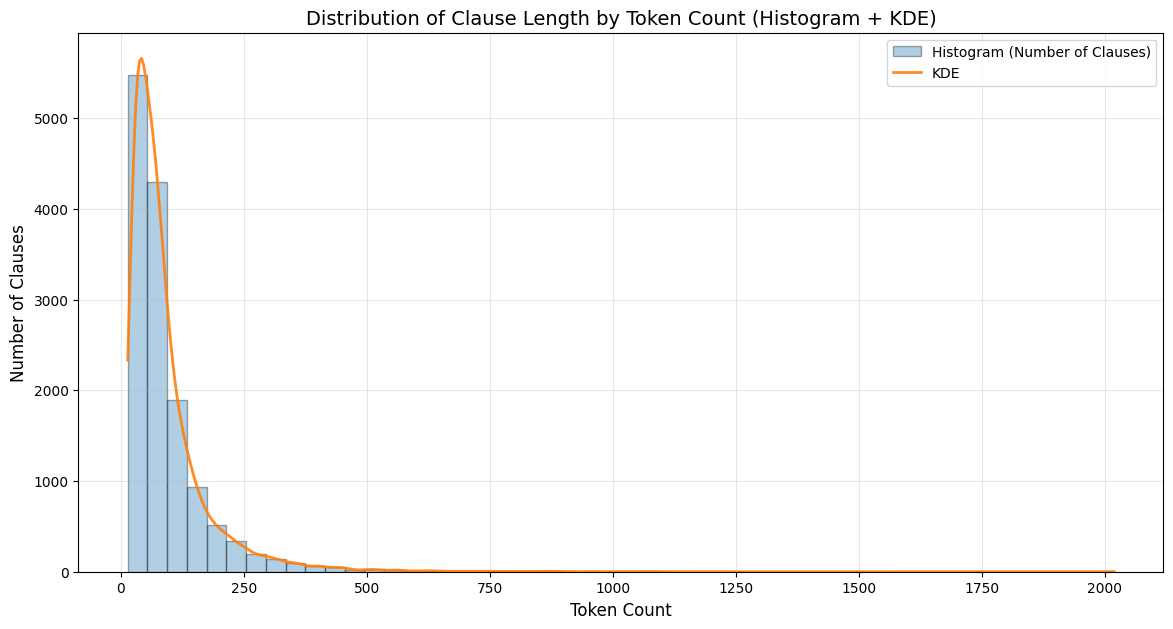

In [5]:
# =========================================
# 1️⃣ Import thư viện
# =========================================
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from transformers import AutoTokenizer

# =========================================
# 2️⃣ Load JSONL file
# =========================================
jsonl_file = "data/keywords_db.jsonl"   # ⬅️ sửa path nếu cần

rows = []
with open(jsonl_file, "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

df = pd.DataFrame(rows)
print(f"✅ Loaded {len(df)} clauses")
display(df.head())

# =========================================
# 3️⃣ Tokenize từng khoản
# =========================================
tokenizer = AutoTokenizer.from_pretrained("AITeamVN/Vi-Qwen2-3B-RAG")

def count_tokens(text):
    return len(tokenizer(text, add_special_tokens=False)["input_ids"])

df["token_count"] = df["clause_text"].apply(count_tokens)
df["char_count"]  = df["clause_text"].apply(len)

# =========================================
# 4️⃣ Thống kê tổng quan trên khoản
# =========================================
data = df["token_count"].values

print("\n===== 📊 THỐNG KÊ TỔNG QUAN TRÊN KHOẢN =====")
print(f"📌 Số khoản: {len(df)}")
print(f"📌 Khoản ngắn nhất (token): {data.min()}")
print(f"📌 Khoản dài nhất (token): {data.max()}")
print(f"📌 Trung bình: {data.mean():.2f}")
print(f"📌 Median: {np.median(data)}")
print(f"📌 Std: {np.std(data):.2f}")
print(f"📌 Percentile 25%: {np.percentile(data, 25)}")
print(f"📌 Percentile 50%: {np.percentile(data, 50)}")
print(f"📌 Percentile 75%: {np.percentile(data, 75)}")
print(f"📌 Percentile 90%: {np.percentile(data, 90)}")
print(f"📌 Percentile 95%: {np.percentile(data, 95)}")
print(f"📌 Percentile 99%: {np.percentile(data, 99)}")

# Top 20 khoản dài nhất
df_sorted = df.sort_values("token_count", ascending=False)
print("\n===== TOP 20 KHOẢN DÀI NHẤT (token) =====")
for i, row in enumerate(df_sorted.head(20).itertuples(), 1):
    print(f"{i}. {row.article_title} / Khoản {row.clause_no}: {row.token_count} tokens")

# =========================================
# 5️⃣ Histogram + KDE overlay (1 biểu đồ)
# =========================================
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(14,7))

# Histogram
counts, bins, patches = plt.hist(
    data,
    bins=50,
    edgecolor="black",
    alpha=0.35,
    label="Histogram (Number of Clauses)"
)

# Scale KDE về cùng đơn vị số khoản
bin_width = bins[1] - bins[0]
plt.plot(
    x_vals,
    y_vals * len(data) * bin_width,
    linewidth=2,
    label="KDE",
    alpha=0.9
)

plt.title("Distribution of Clause Length by Token Count (Histogram + KDE)", fontsize=14)
plt.xlabel("Token Count", fontsize=12)
plt.ylabel("Number of Clauses", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
